In [1]:
from dataclasses import dataclass

import geometry
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from IPython import display as ipythondisplay

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.6
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0}


In [3]:
env = Simulator("small_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[1,0],
    seed=42,
    max_steps=float("inf"),
)

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data


In [6]:
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], 0]

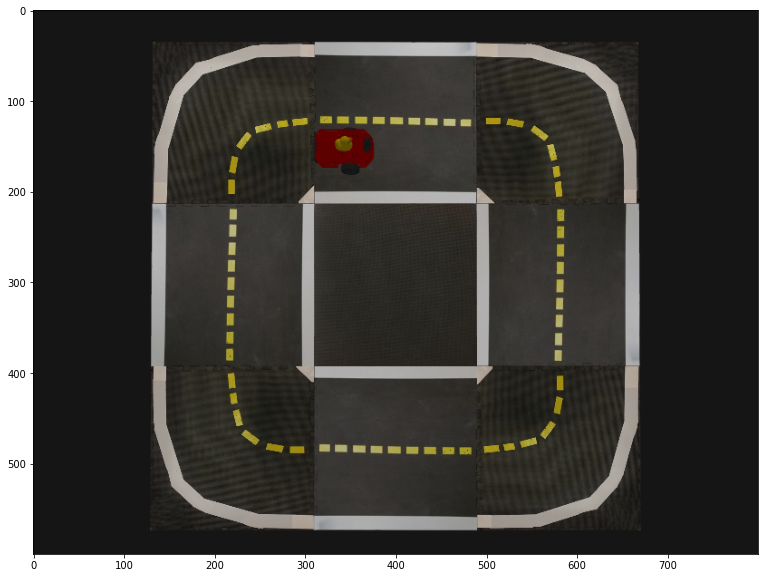

In [14]:
env.reset()
top_view = np.flip(env.render(mode="top_down"), [0])
plt.imshow(top_view)

In [8]:
import cv2

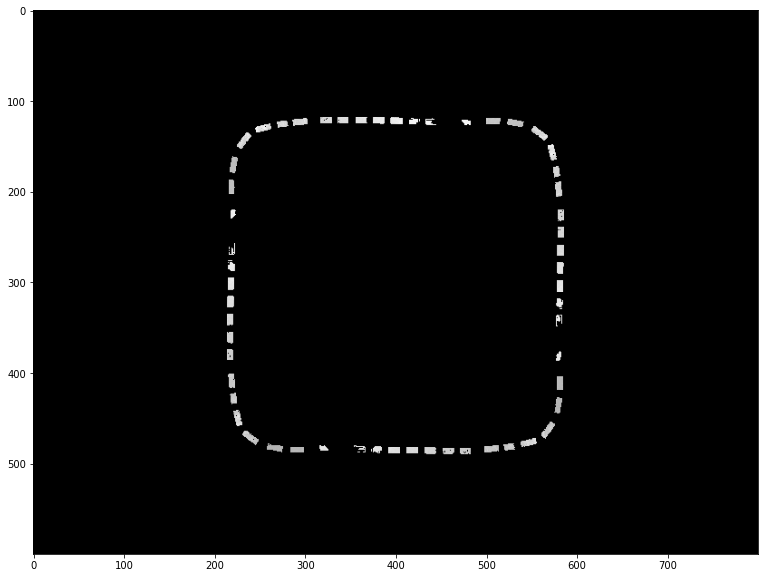

In [42]:
img_hsv = cv2.cvtColor(top_view, cv2.COLOR_RGB2HSV)
gray = cv2.cvtColor(top_view, cv2.COLOR_RGB2GRAY)

lower_yellow = np.array([20,100,150])
upper_yellow = np.array([30,255,255])

mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
mask_y_image = cv2.bitwise_and(gray, mask_yellow)

plt.imshow(mask_y_image, cmap='gray')